# DATA PREPARATION

In [1]:
# %load resolve.py
from collections import Counter
from os.path import join
from os.path import splitext
from os import listdir
import xml.etree.ElementTree as ET

PATH = './resources'
OUTPUT = './output'

MENTIONS_DIR = 'Mentions'
CHAINS_DIR = 'Chains'
NS = {'Aux': 'http://www.abbyy.com/ns/Aux#',
      'rdf': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#'}


def init():
    mentions_path = join(PATH, MENTIONS_DIR)
    chains_path = join(PATH, CHAINS_DIR)
    for filename in listdir(mentions_path):
        with open(join(mentions_path, filename)) as f:
            mentions_content = f.read()
        with open(join(chains_path, filename)) as f:
            chains_content = f.read()
        mentions = parse_xml(mentions_content)
        chains = parse_xml(chains_content)
        merged = {**chains, **mentions}
        merged_sorted_keys = sorted(merged.keys(), key=lambda mention: mention[0])
        output_filename = splitext(filename)[0] + '.txt'
        with open(join(OUTPUT, MENTIONS_DIR, output_filename), 'w+') as f:
            count = 1
            for (start, length) in merged_sorted_keys:
                merged[(start, length)]['id'] = count
                f.write('{} {} {}\n'.format(count, start, length))
                count += 1
        chains_counter = Counter(list(map(lambda d: d['node_id'], chains.values())))
        chains_sorted_keys = sorted(chains.keys(), key=lambda chain: chain[0])
        with open(join(OUTPUT, CHAINS_DIR, output_filename), 'w+') as f:
            chain_seq_index = {}
            count = 1
            for (start, length) in chains_sorted_keys:
                chain_id = chains[(start, length)]['node_id']
                chain_len = chains_counter[chain_id]
                if chain_len <= 1:
                    continue
                if chain_id in chain_seq_index:
                    chain_seq_num = chain_seq_index[chain_id]
                else:
                    chain_seq_num = count
                    chain_seq_index[chain_id] = chain_seq_num
                    count += 1
                f.write('{} {} {} {}\n'.format(merged[(start, length)]['id'], start, length, chain_seq_num))


# parse xml content into dict {(start, length): {'node_id': <id>}}
# each entry corresponds to InstanceAnnotation elem
def parse_xml(xml_content):
    entries = {}
    for ann in get_annotations(xml_content):
        instance_ann = ann.find('Aux:InstanceAnnotation', NS)
        start, length, node_id = prepare_entry_elems(instance_ann)
        entries[(start, length)] = {'node_id': node_id}
    return entries


def get_annotations(xml_content):
    root = ET.fromstring(xml_content)
    text_ann = root.find('Aux:TextAnnotations', NS)
    return text_ann.findall('Aux:annotation', NS)


def prepare_entry_elems(instance_ann):
    start = int(instance_ann.find('Aux:annotation_start', NS).text)
    end = int(instance_ann.find('Aux:annotation_end', NS).text)
    instance = instance_ann.find('Aux:instance', NS)
    instance_id = instance.attrib['{{{}}}nodeID'.format(NS['rdf'])]
    return start, end - start, instance_id


init()


In [2]:
XML_PATH = join(PATH, CHAINS_DIR)
CHAINS_PATH = join(OUTPUT, CHAINS_DIR)

In [3]:
# extract original text from xml content
def extract_text(xml_content):
    root = ET.fromstring(xml_content)
    text_ann = root.find('Aux:TextAnnotations', NS)
    doc_text = text_ann.find('Aux:document_text', NS)
    if doc_text is not None:
        return doc_text.text
    else:
        return ''

In [4]:
# build data frame row
def build_row(mention_1, mention_2, start_1, start_2, len_1, text_len, are_from_same_group):
    men_1_lower = mention_1.lower()
    men_2_lower = mention_2.lower()
    row = {}
    row['Equality'] = int(men_1_lower == men_2_lower)
    row['M1ContainsM2'] = int(men_1_lower in men_2_lower)
    row['M2ContainsM1'] = int(men_2_lower in men_1_lower)
    row['Distance'] = start_2 - (start_1 + len_1)
    row['RelativeDistance'] = row['Distance'] / text_len
    row['Mention1'] = mention_1
    row['Mention2'] = mention_2
    row['SameGroup'] = int(are_from_same_group)
    return row

In [5]:
rows_list = []
for filename in listdir(XML_PATH):
    with open(join(XML_PATH, filename)) as f:
        xml_content = f.read()
    text = extract_text(xml_content)
    text_len = len(text)
    print(f'Filename - {filename} ; length - {text_len}')
    if text_len > 0:
        chains_entries = []
        chains_filename = splitext(filename)[0] + '.txt'
        with open(join(CHAINS_PATH, chains_filename)) as f:
            for line in f:
                chains_entries.append(tuple(map(lambda x: int(x),line.strip().split(' '))))
        count = 0
        chains_entries_len = len(chains_entries)
        for i in range(chains_entries_len):
            _, start_i, len_i, chain_i = chains_entries[i]
            men_i = text[start_i:start_i+len_i]
            for j in range(i+1, chains_entries_len):
                _, start_j, len_j, chain_j = chains_entries[j]
                men_j = text[start_j:start_j+len_j]
                row = build_row(men_i, men_j, start_i, start_j, len_i, text_len, chain_i == chain_j)
                rows_list.append(row)
                count += 1
        print(f'Number of chains entries - {len(chains_entries)} ; Number of mention pairs - {count}')
    else:
        print('No chains: text is empty.')
    print()

Filename - book_1719.xml ; length - 1386
Number of chains entries - 25 ; Number of mention pairs - 300

Filename - book_3503.xml ; length - 3525
Number of chains entries - 66 ; Number of mention pairs - 2145

Filename - book_102.xml ; length - 5510
Number of chains entries - 78 ; Number of mention pairs - 3003

Filename - book_3590.xml ; length - 0
No chains: text is empty.

Filename - book_1574.xml ; length - 1449
Number of chains entries - 22 ; Number of mention pairs - 231

Filename - book_1206.xml ; length - 1590
Number of chains entries - 31 ; Number of mention pairs - 465

Filename - book_2844.xml ; length - 1213
Number of chains entries - 15 ; Number of mention pairs - 105

Filename - book_3857.xml ; length - 2631
Number of chains entries - 50 ; Number of mention pairs - 1225

Filename - book_1871.xml ; length - 641
Number of chains entries - 8 ; Number of mention pairs - 28

Filename - book_2891.xml ; length - 5575
Number of chains entries - 120 ; Number of mention pairs - 7140

Number of chains entries - 160 ; Number of mention pairs - 12720

Filename - book_2008.xml ; length - 137
Number of chains entries - 2 ; Number of mention pairs - 1

Filename - book_3538.xml ; length - 18621
Number of chains entries - 388 ; Number of mention pairs - 75078

Filename - book_3700.xml ; length - 5204
Number of chains entries - 107 ; Number of mention pairs - 5671

Filename - book_1538.xml ; length - 633
Number of chains entries - 9 ; Number of mention pairs - 36

Filename - book_3935.xml ; length - 3055
Number of chains entries - 70 ; Number of mention pairs - 2415

Filename - book_1043.xml ; length - 697
Number of chains entries - 8 ; Number of mention pairs - 28

Filename - book_2248.xml ; length - 4155
Number of chains entries - 58 ; Number of mention pairs - 1653

Filename - book_3625.xml ; length - 1076
Number of chains entries - 22 ; Number of mention pairs - 231

Filename - book_3994.xml ; length - 0
No chains: text is empty.

Filename - book_3352.xml ; length - 255

In [17]:
import pandas as pd
df = pd.DataFrame(rows_list)
df.head()

,Distance,Equality,M1ContainsM2,M2ContainsM1,Mention1,Mention2,RelativeDistance,SameGroup
0,62,0,1,0,Дюссельдорф,Дюссельдорфа,0.044733,1
1,121,0,0,0,Дюссельдорф,мэрия города,0.087302,0
2,127,0,0,0,Дюссельдорф,города,0.091631,1
3,151,0,0,0,Дюссельдорф,бесплатную брошюру,0.108947,0
4,231,0,1,0,Дюссельдорф,Дюссельдорфа,0.166667,1


In [18]:
features = ['Distance', 'Equality', 'M1ContainsM2', 'M2ContainsM1', 'RelativeDistance']
target = 'SameGroup'

X = df.loc[:, features]
y = df.loc[:, target]

In [25]:
# Split the data set and create two data sets.
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=143)
print("Number of training records: " + str(X_train.shape[0]))
print("Number of testing records : " + str(X_test.shape[0]))

Number of training records: 206677
Number of testing records : 111288


# CLASSIFICATION MODEL

In [81]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

## Model with Default Parameters

In [82]:
model = XGBClassifier()

In [84]:
# Train and evaluate.
model.fit(X_train, y_train,
          eval_metric=['error'],
          eval_set=[((X_train, y_train)),(X_test, y_test)],
          early_stopping_rounds=50,
          verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [85]:
from matplotlib import pyplot

%matplotlib inline

Text(0.5, 0, 'Number of iterations')

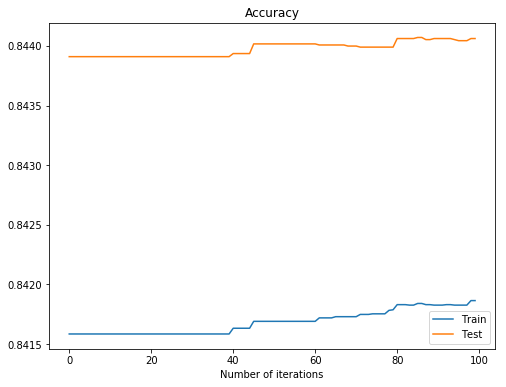

In [87]:
# Plot and display the performance evaluation
xgb_eval = model.evals_result()
eval_steps = range(len(xgb_eval['validation_0']['error']))

fig, ax = pyplot.subplots(1, 1, sharex=True, figsize=(8, 6))

ax.plot(eval_steps, [1-x for x in xgb_eval['validation_0']['error']], label='Train')
ax.plot(eval_steps, [1-x for x in xgb_eval['validation_1']['error']], label='Test')
ax.legend()
ax.set_title('Accuracy')
ax.set_xlabel('Number of iterations')

In [88]:
print("Model best validation score :", model.best_score)
print("Model best number of tree limit :", model.best_ntree_limit)

Model best validation score : 0.155929
Model best number of tree limit : 86


In [89]:
# Check the accuracy of the trained model.
n_trees = 86
y_pred = model.predict(X_test, ntree_limit= n_trees)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy: %.1f%%" % (accuracy * 100.0))

Accuracy: 84.4%


Text(0, 0.5, 'Feature Importance Score')

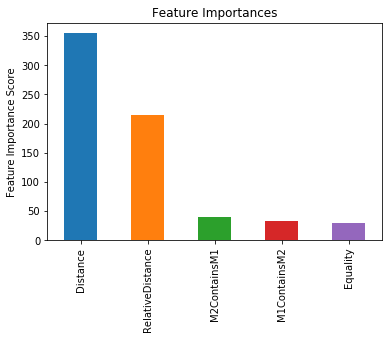

In [90]:
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

## Parameters Tuning

### max_depth and min_child_weight

In [102]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
model1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=86,
        max_depth=3,
        min_child_weight=1,
        gamma=0,
        subsample=1,
        colsample_bytree=1,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27
    )
gsearch1 = GridSearchCV(estimator = model1, param_grid = param_test1, scoring='accuracy',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X,y)
pd.DataFrame(gsearch1.cv_results_, columns=['mean_fit_time', 'params', 'mean_train_score', 'mean_test_score'])

,mean_fit_time,params,mean_train_score,mean_test_score
0,42.735860,"{'max_depth': 3, 'min_child_weight': 1}",0.843098,0.836516
1,40.920039,"{'max_depth': 3, 'min_child_weight': 3}",0.843087,0.836856
2,40.881011,"{'max_depth': 3, 'min_child_weight': 5}",0.843113,0.836611
3,65.062265,"{'max_depth': 5, 'min_child_weight': 1}",0.844248,0.814124
4,67.289868,"{'max_depth': 5, 'min_child_weight': 3}",0.844144,0.812463
5,65.683267,"{'max_depth': 5, 'min_child_weight': 5}",0.844135,0.814507
6,92.978738,"{'max_depth': 7, 'min_child_weight': 1}",0.846033,0.796203
7,96.238243,"{'max_depth': 7, 'min_child_weight': 3}",0.846040,0.798112
8,93.374431,"{'max_depth': 7, 'min_child_weight': 5}",0.845783,0.802654
9,121.490772,"{'max_depth': 9, 'min_child_weight': 1}",0.848214,0.771433


In [103]:
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 3, 'min_child_weight': 3}, 0.8368561539745535)

### gamma

In [104]:
param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
model2 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=86,
        max_depth=3,
        min_child_weight=3,
        gamma=0,
        subsample=1,
        colsample_bytree=1,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27
    )
gsearch2 = GridSearchCV(estimator = model2, param_grid = param_test2, scoring='accuracy',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X,y)
pd.DataFrame(gsearch2.cv_results_, columns=['mean_fit_time', 'params', 'mean_train_score', 'mean_test_score'])

,mean_fit_time,params,mean_train_score,mean_test_score
0,41.250088,{'gamma': 0.0},0.843087,0.836856
1,42.576552,{'gamma': 0.1},0.843084,0.836561
2,40.915431,{'gamma': 0.2},0.843099,0.836510
3,41.575056,{'gamma': 0.3},0.843131,0.836290
4,35.467944,{'gamma': 0.4},0.843118,0.836274


In [109]:
gsearch2.best_params_, gsearch2.best_score_

({'gamma': 0.0}, 0.8368561539745535)

### subsample and colsample_bytree

In [107]:
param_test3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
model3 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=86,
        max_depth=3,
        min_child_weight=3,
        gamma=0,
        subsample=1,
        colsample_bytree=1,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27
    )
gsearch3 = GridSearchCV(estimator = model3, param_grid = param_test3, scoring='accuracy',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X,y)
pd.DataFrame(gsearch3.cv_results_, columns=['mean_fit_time', 'params', 'mean_train_score', 'mean_test_score'])

,mean_fit_time,params,mean_train_score,mean_test_score
0,40.470679,"{'colsample_bytree': 0.6, 'subsample': 0.6}",0.842734,0.839183
1,41.392617,"{'colsample_bytree': 0.6, 'subsample': 0.7}",0.842752,0.838998
2,39.552601,"{'colsample_bytree': 0.6, 'subsample': 0.8}",0.842722,0.839328
3,40.632847,"{'colsample_bytree': 0.6, 'subsample': 0.9}",0.842762,0.839312
4,39.605746,"{'colsample_bytree': 0.7, 'subsample': 0.6}",0.842734,0.839183
5,40.420311,"{'colsample_bytree': 0.7, 'subsample': 0.7}",0.842752,0.838998
6,40.678979,"{'colsample_bytree': 0.7, 'subsample': 0.8}",0.842722,0.839328
7,39.754985,"{'colsample_bytree': 0.7, 'subsample': 0.9}",0.842762,0.839312
8,43.186412,"{'colsample_bytree': 0.8, 'subsample': 0.6}",0.843041,0.830978
9,41.973216,"{'colsample_bytree': 0.8, 'subsample': 0.7}",0.843111,0.836318


In [110]:
gsearch3.best_params_, gsearch3.best_score_

({'colsample_bytree': 0.6, 'subsample': 0.8}, 0.8393281588286079)

## Model with Tuned Parameters

In [137]:
model_final = XGBClassifier(
        learning_rate =0.05, # reduce learning rate
        n_estimators=1000, # add more trees
        max_depth=3,
        min_child_weight=3,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.6,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27
    )

In [140]:
model_final.fit(X_train, y_train,
                eval_metric=['error'],
                eval_set=[((X_train, y_train)),(X_test, y_test)],
                early_stopping_rounds=300,
                verbose=False)

print("Model best validation score :", model_final.best_score)
print("Model best number of tree limit :", model_final.best_ntree_limit)

Model best validation score : 0.155497
Model best number of tree limit : 998


In [141]:
n_trees = 998
y_pred = model_final.predict(X_test, ntree_limit= n_trees)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy: %.1f%%" % (accuracy * 100.0))

Accuracy: 84.5%
